In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [4]:
from datasets import load_dataset

dataset_name = "dim/nfs_pix2pix_1920_1080_v5"
# dataset_name = "dim/nfs_pix2pix_1920_1080_v6"
dataset = load_dataset(dataset_name, num_proc=4)
dataset = dataset["train"]

In [4]:
dataset[0]["edit_prompt"]

'make nfs 2005 photorealistic'

In [ ]:
dataset[180]["edited_image"]

In [1]:
import os

# os.chdir("/code/img2img_turbo/src")
import argparse
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
from img2img_turbo.src.pix2pix_turbo import Pix2Pix_Turbo
from img2img_turbo.src.image_prep import canny_from_pil
from img2img_turbo.src.benchmark import merge_loras

model_name = ""
# model_path = "/code/img2img_turbo/models/model_20001.pkl"
model_path = "img2img-turbo/output/pix2pix_turbo/nfs_pix2pix_1736652315/checkpoints/model_7201.pkl"
use_fp16 = not False

# initialize the model
model = Pix2Pix_Turbo(pretrained_name=model_name, pretrained_path=model_path)
merge_loras(model=model)
model.set_eval()
# if use_fp16:
# model.to(torch.bfloat16)
# model.unet.to(torch.bfloat16)
# model.vae.to(torch.bfloat16)

T = transforms.Compose(
    [
        transforms.Resize(512, interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.CenterCrop(512),
    ]
)

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/user-name-goes-here/.local/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/user-name-goes-here/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you w

In [11]:
# не работает для sd turbo
# from safetensors.torch import load_file
# from diffusers.loaders.lora_conversion_utils import (
#     _convert_non_diffusers_lora_to_diffusers,
# )


# state_dict = load_file("img2img_turbo/models/pytorch_lora_weights.safetensors")


# new_state_dict, network_alphas = _convert_non_diffusers_lora_to_diffusers(
#     state_dict, unet_name=""
# )

In [14]:
# new_state_dict[".down_blocks.0.attentions.0.proj_in.lora.down.weight"].shape

torch.Size([64, 320, 1, 1])

In [16]:
# for key in list(new_state_dict.keys()):
#     new_state_dict[key[1:]] = new_state_dict.pop(key)

In [3]:
# не работает из коробки
# from diffusers import AutoencoderTiny, StableDiffusionPipeline

# model.vae = AutoencoderTiny.from_pretrained("madebyollin/taesd").to(
#     device="cuda",
#     dtype=torch.bfloat16,
# )

In [ ]:
# model.unet.load_lora_adapter(
#     new_state_dict, network_alphas=network_alphas, unet=model.unet, strict=False
# )
# model.unet.fuse_lora()

In [17]:
model.timesteps = torch.tensor([999], device="cuda:0")

In [37]:
model.sched.set_timesteps(1, "cuda")

In [40]:
# merge_loras(model=model)
# model.unet.to(torch.bfloat16)
# None

In [ ]:
# for item in model.named_parameters():
#     print(item[0])

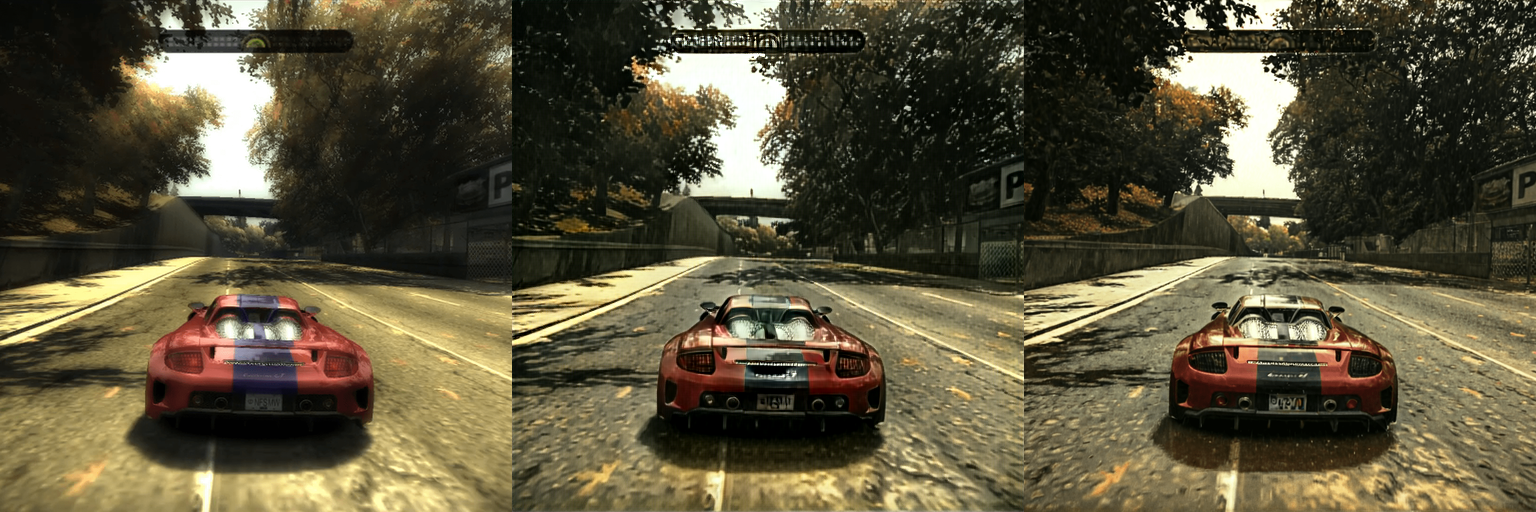

In [6]:
pos = 190
input_image = dataset[pos]["input_image"].convert("RGB")
prompt = dataset[0]["edit_prompt"]
target_image = T(dataset[pos]["edited_image"].convert("RGB"))
with torch.no_grad():
    i_t = T(input_image)
    # i_t = input_image
    c_t = F.to_tensor(i_t).unsqueeze(0)
    # if use_fp16:
    # c_t = c_t.to(torch.bfloat16).cuda()
    c_t = c_t.cuda()
    # output_image = model(c_t, prompt)
    output_image = model.custom_forward(c_t, prompt)

    output_pil = transforms.ToPILImage()(output_image[0].cpu() * 0.5 + 0.5)
    dst = Image.new("RGB", (output_pil.width * 3, output_pil.height))
    dst.paste(i_t, (0, 0))
    dst.paste(output_pil, (output_pil.width, 0))
    dst.paste(target_image, (output_pil.width * 2, 0))

dst

### Save to Folder

In [8]:
import os
from tqdm import tqdm
start_pos = 170
end_pos = 570
save_folder = "comfyui_sandbox/video_renders/render_img2img_turbo_2"
os.system(f"mkdir -p {save_folder}")

with torch.no_grad():
    for pos in tqdm(range(start_pos, end_pos)):
        input_image = dataset[pos]["input_image"].convert("RGB")
        prompt = dataset[0]["edit_prompt"]
        target_image = T(dataset[pos]["edited_image"].convert("RGB"))

        i_t = T(input_image)
        # i_t = input_image
        c_t = F.to_tensor(i_t).unsqueeze(0)
        # if use_fp16:
        # c_t = c_t.to(torch.bfloat16).cuda()
        c_t = c_t.cuda()
        # output_image = model(c_t, prompt)
        output_image = model.custom_forward(c_t, prompt)

        output_pil = transforms.ToPILImage()((output_image[0] * 0.5 + 0.5).cpu())
        dst = Image.new("RGB", (output_pil.width * 3, output_pil.height))
        dst.paste(i_t, (0, 0))
        dst.paste(output_pil, (output_pil.width, 0))
        dst.paste(target_image, (output_pil.width * 2, 0))

        dst.save(f"{save_folder}/{pos}.png")

100%|██████████| 400/400 [03:50<00:00,  1.73it/s]


In [ ]:
model

In [ ]:
# huggingface-cli upload dim/nfs_pix2pix_1736605715 /code/img2img-turbo/output/pix2pix_turbo/nfs_pix2pix_1736605715/checkpoints/model_20001.pkl model_20001.pkl

In [ ]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id_or_path, torch_dtype=torch.float16
)
pipe = pipe.to(device)

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "A fantasy landscape, trending on artstation"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
images[0].save("fantasy_landscape.png")